<a href="https://colab.research.google.com/github/Hafsa-malik786/PAI/blob/main/BERT_FINETUNING_on_tweet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers torch scikit-learn


In [1]:
!pip install kaggle

In [2]:
import os
import json

with open('/content/kaggle.json') as f:
  kaggle_json=json.load(f)

os.environ['KAGGLE_USERNAME']=kaggle_json['username']
os.environ['KAGGLE_KEY']=kaggle_json['key']

In [3]:
!kaggle datasets download  seriousran/appletwittersentimenttexts

Dataset URL: https://www.kaggle.com/datasets/seriousran/appletwittersentimenttexts
License(s): other
  0% 0.00/71.0k [00:00<?, ?B/s]
100% 71.0k/71.0k [00:00<00:00, 48.9MB/s]


In [4]:
!unzip appletwittersentimenttexts.zip

Archive:  appletwittersentimenttexts.zip
  inflating: apple-twitter-sentiment-texts.csv  


Import Libraries

In [5]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from transformers import BertTokenizer,BertForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from torch.utils.data import DataLoader, TensorDataset


Load and Preprocess Data

In [6]:
df=pd.read_csv('apple-twitter-sentiment-texts.csv')

In [7]:
df.head()

,text,sentiment
0,Wow. Yall needa step it up @Apple RT @heynyla:...,-1
1,What Happened To Apple Inc? http://t.co/FJEX...,0
2,Thank u @apple I can now compile all of the pi...,1
3,The oddly uplifting story of the Apple co-foun...,0
4,@apple can i exchange my iphone for a differen...,0


In [8]:
df.shape

(1630, 2)

In [9]:
#check null values
df.isnull().sum()

,0
text,0
sentiment,0


In [10]:
# Preprocess text
import re

def preprocess(text):
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'@\w+', '', text)     # Remove mentions
    text = re.sub(r'[^A-Za-z\s]', '', text)  # Remove special characters
    text = text.lower().strip()          # Convert to lowercase and strip
    return text

df['text'] = df['text'].apply(preprocess)


In [11]:
# Map sentiment labels to non-negative integers
label_mapping = {-1: 0, 0: 1, 1: 2}  # Map -1 -> 0 (negative), 0 -> 1 (neutral), 1 -> 2 (positive)
df['sentiment'] = df['sentiment'].map(label_mapping)


In [12]:
print(df['sentiment'].unique())

[0 1 2]


In [13]:
# Split into training and validation sets
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

Tokenize Data

In [15]:
# Tokenization
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def tokenize_function(texts):
    return tokenizer(texts, padding='max_length', truncation=True, return_tensors='pt', max_length=128)

train_encodings = tokenize_function(train_df['text'].tolist())
val_encodings = tokenize_function(val_df['text'].tolist())

train_labels = torch.tensor(train_df['sentiment'].tolist())
val_labels = torch.tensor(val_df['sentiment'].tolist())

Create DataLoader

In [16]:
# DataLoader
train_dataset = TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'], train_labels)
val_dataset = TensorDataset(val_encodings['input_ids'], val_encodings['attention_mask'], val_labels)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128)

Initialize Model Components

In [17]:
# Load BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)

# Define optimizer and learning rate
optimizer = AdamW(model.parameters(), lr=1e-5)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [18]:
# Move model to GPU if available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

Training Loop

In [19]:
# Training loop
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        input_ids, attention_mask, labels = [b.to(device) for b in batch]

        # Forward pass
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

    avg_train_loss = total_loss / len(train_loader)
    print(f'Epoch {epoch+1}, Training loss: {avg_train_loss}')


Epoch 1, Training loss: 1.0059240677139976
Epoch 2, Training loss: 0.865717275576158
Epoch 3, Training loss: 0.725410981611772
Epoch 4, Training loss: 0.6372553977099332
Epoch 5, Training loss: 0.5545392198996111


In [20]:
from tqdm import tqdm
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    # Wrap train_loader with tqdm to show progress bar
    with tqdm(train_loader, unit="batch", desc=f"Epoch {epoch+1}") as t:
        for batch in t:
            optimizer.zero_grad()
            input_ids, attention_mask, labels = [b.to(device) for b in batch]

            # Forward pass
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_loss += loss.item()

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Update progress bar with the loss value
            t.set_postfix(loss=total_loss / (t.n + 1))

    avg_train_loss = total_loss / len(train_loader)
    print(f'Epoch {epoch+1}, Training loss: {avg_train_loss}')


Epoch 1: 100%|██████████| 11/11 [00:22<00:00,  2.08s/batch, loss=0.477]


Epoch 1, Training loss: 0.47735485434532166


Epoch 2: 100%|██████████| 11/11 [00:23<00:00,  2.11s/batch, loss=0.391]


Epoch 2, Training loss: 0.3913536911660975


Epoch 3: 100%|██████████| 11/11 [00:23<00:00,  2.13s/batch, loss=0.314]


Epoch 3, Training loss: 0.31371711126782675


Epoch 4: 100%|██████████| 11/11 [00:23<00:00,  2.17s/batch, loss=0.256]


Epoch 4, Training loss: 0.2560838894410567


Epoch 5: 100%|██████████| 11/11 [00:24<00:00,  2.20s/batch, loss=0.211]


Epoch 5, Training loss: 0.21102564443241467


Epoch 6: 100%|██████████| 11/11 [00:24<00:00,  2.23s/batch, loss=0.181]


Epoch 6, Training loss: 0.18056980317289179


Epoch 7: 100%|██████████| 11/11 [00:24<00:00,  2.21s/batch, loss=0.147]


Epoch 7, Training loss: 0.1471619646657597


Epoch 8: 100%|██████████| 11/11 [00:24<00:00,  2.20s/batch, loss=0.108]


Epoch 8, Training loss: 0.10804709961468523


Epoch 9: 100%|██████████| 11/11 [00:24<00:00,  2.22s/batch, loss=0.088]


Epoch 9, Training loss: 0.0880074565383521


Epoch 10: 100%|██████████| 11/11 [00:24<00:00,  2.21s/batch, loss=0.0745]

Epoch 10, Training loss: 0.07446021247993816


In [27]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import torch

# Evaluation loop
model.eval()  # Set the model to evaluation mode
all_preds = []
all_labels = []

# Disable gradient computation for evaluation
with torch.no_grad():
    for batch in val_loader:
        input_ids, attention_mask, labels = [b.to(device) for b in batch]

        # Forward pass
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits  # Get the logits (predictions before applying activation function)

        # Get the predicted class labels (with the highest logit value)
        preds = torch.argmax(logits, dim=1)

        all_preds.extend(preds.cpu().numpy())  # Move to CPU and convert to numpy array
        all_labels.extend(labels.cpu().numpy())  # Move to CPU and convert to numpy array

# Convert lists to numpy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Calculate metrics
accuracy = accuracy_score(all_labels, all_preds)
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')

# Display metrics
print(f"Validation Accuracy: {accuracy:.4f}")
print(f"Validation Precision: {precision:.4f}")
print(f"Validation Recall: {recall:.4f}")
print(f"Validation F1 Score: {f1:.4f}")


Validation Accuracy: 0.8834
Validation Precision: 0.8806
Validation Recall: 0.8834
Validation F1 Score: 0.8815


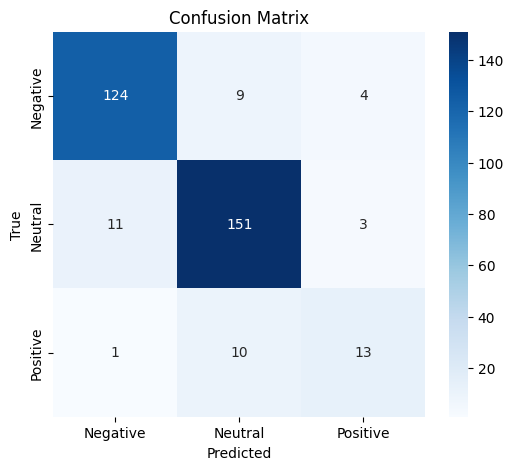

In [26]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [29]:
from sklearn.metrics import classification_report
# Classification Report
report = classification_report(all_labels, all_preds, target_names=['Negative', 'Neutral', 'Positive'])
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

    Negative       0.91      0.91      0.91       137
     Neutral       0.89      0.92      0.90       165
    Positive       0.65      0.54      0.59        24

    accuracy                           0.88       326
   macro avg       0.82      0.79      0.80       326
weighted avg       0.88      0.88      0.88       326

